# Adaptive LDA All Subjects

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import os
import glob

from Rules import GameRules
from LDA_adaptive import aLDA
from LDA_adaptive import print_array, load_data

from jupyterthemes import jtplot
jtplot.reset()

## Augmented Rule

In [2]:
all_IDs = ["ID#31127011_2WProsthUse", "ID#31180011_2WProsthUse", "ID#32068222_2WProsthUse", 
               "ID#32098021_2WProsthUse", "ID#32132721_2WProsthUse", "ID#32136722_2WProsthUse",
               "ID#32195432_2WProsthUse", "ID#51013322_2WProsthUse", "ID#51048532_2WProsthUse", 
               "ID#52054922_2WProsthUse"]

""" Read in all In the Zone game data for all subjects"""
""" Prime subjects: ID#32068222_2WProsthUse(2), ID#32136722_2WProsthUse(5), ID#51048532_2WProsthUse(8), ID#52054922_2WProsthUse(9)"""
all_subjects_games = []
all_subjects_thresh = []
for selected_user in all_IDs:
    Gamedata = load_data(selected_user)
    all_subjects_games.append(Gamedata)
    print(f"Total games: {len(Gamedata)}")

    path = os.getcwd()
    csv_files = glob.glob(os.path.join(path, f"../Data/{selected_user}/VirtualGameData/ClassMeans*"))
    csv_files = sorted(csv_files)

    # use the first class means file
    flag = 0
    for i in csv_files:
        if flag < 1:
            classmeans = pd.read_csv(i, header=None).to_numpy()
            print(i)
            flag += 1

    # first array is for 0
    classmeans = classmeans[:,1:]
    classmeans = classmeans[:, 0::7]
    noMotion_thresh = 1.1 * np.mean(classmeans[0])
    all_subjects_thresh.append(noMotion_thresh)
    print(f"No motion threshold: {noMotion_thresh}")

thresh_count = 0
for Gamedata in all_subjects_games:
    for file in Gamedata:
        counter = 0
        for ind in file.index:
            curr_mean = file[['emgChan1', 'emgChan2', 'emgChan3', 'emgChan4', 'emgChan5', 'emgChan6', 'emgChan7', 'emgChan8']].iloc[counter].mean()
            if curr_mean < all_subjects_thresh[thresh_count]:
                file.at[ind, 'targetClass'] = 0
            counter += 1
        print(f"Number of no motions: {np.sum(file['targetClass'] == 0)}")
    thresh_count += 1
    print("")

Game data paths:
/home/androo/Documents/Coapt/Code/../Data/ID#31127011_2WProsthUse/VirtualGameData/VirtualArmGames_1.csv
/home/androo/Documents/Coapt/Code/../Data/ID#31127011_2WProsthUse/VirtualGameData/VirtualArmGames_3.csv
/home/androo/Documents/Coapt/Code/../Data/ID#31127011_2WProsthUse/VirtualGameData/VirtualArmGames_5.csv
/home/androo/Documents/Coapt/Code/../Data/ID#31127011_2WProsthUse/VirtualGameData/VirtualArmGames_8.csv
/home/androo/Documents/Coapt/Code/../Data/ID#31127011_2WProsthUse/VirtualGameData/VirtualArmGames_11.csv
/home/androo/Documents/Coapt/Code/../Data/ID#31127011_2WProsthUse/VirtualGameData/VirtualArmGames_15.csv
/home/androo/Documents/Coapt/Code/../Data/ID#31127011_2WProsthUse/VirtualGameData/VirtualArmGames_17.csv
Total games: 7
/home/androo/Documents/Coapt/Code/../Data/ID#31127011_2WProsthUse/VirtualGameData/ClassMeans-1_21_2021_18_26_17.csv
No motion threshold: 156.2616668701172
Game data paths:
/home/androo/Documents/Coapt/Code/../Data/ID#31180011_2WProsthUse

Total games: 8
/home/androo/Documents/Coapt/Code/../Data/ID#32195432_2WProsthUse/VirtualGameData/ClassMeans-3_10_2021_17_56_54.csv
No motion threshold: 684.5744470596314
Game data paths:
/home/androo/Documents/Coapt/Code/../Data/ID#51013322_2WProsthUse/VirtualGameData/VirtualArmGames_2.csv
/home/androo/Documents/Coapt/Code/../Data/ID#51013322_2WProsthUse/VirtualGameData/VirtualArmGames_4.csv
/home/androo/Documents/Coapt/Code/../Data/ID#51013322_2WProsthUse/VirtualGameData/VirtualArmGames_5.csv
/home/androo/Documents/Coapt/Code/../Data/ID#51013322_2WProsthUse/VirtualGameData/VirtualArmGames_6.csv
/home/androo/Documents/Coapt/Code/../Data/ID#51013322_2WProsthUse/VirtualGameData/VirtualArmGames_8.csv
/home/androo/Documents/Coapt/Code/../Data/ID#51013322_2WProsthUse/VirtualGameData/VirtualArmGames_10.csv
/home/androo/Documents/Coapt/Code/../Data/ID#51013322_2WProsthUse/VirtualGameData/VirtualArmGames_12.csv
/home/androo/Documents/Coapt/Code/../Data/ID#51013322_2WProsthUse/VirtualGameData/V

In [3]:
all_subjects_unadapted = []
all_subjects_unadapted_wrules = []
all_subjects_adapted = []
all_subjects_adapted_wrules = []
all_subjects_baseline = []
for subject in all_subjects_games:
    unadapted_err = []
    unadapted_wrules_err = []
    adapted_err = []
    adapted_wrules_err = []
    baseline = []
    first_flag = 0
    for game in subject:
        class_data = game[['class', 'targetClass', 'emgChan1', 'emgChan2', 'emgChan3', 'emgChan4', 'emgChan5', 'emgChan6', 'emgChan7', 'emgChan8']].to_numpy()

        if first_flag < 1:
            init_err = np.around(((class_data[:,0]!=class_data[:, 1]).sum() / class_data[:, 1].size), 2) * 100
            print("Error Rates")
            print(f"1 baseline: {init_err}%")
            baseline.append(init_err)

            """ Unadapted """
            X = class_data[:, 2:]
            y = class_data[:, 1]

            np.random.seed(42)
            combined = np.hstack((X,y.reshape(len(y),1)))
            np.random.shuffle(combined)
            adapt_sample = combined[:len(y)//2, :]
            test_sample = combined[len(y)//2:, :]

            X = adapt_sample[:, :-1]
            y = adapt_sample[:, -1]

            lda = aLDA()
            _, _ = lda.fit(X, y, flag=0)

            X = test_sample[:, :-1]
            y = test_sample[:, -1]
            lda_preds = lda.predict(X)

            # print_array(y)
            # print_array(lda_preds)

            print(f"1 unadapted: {np.around((y!=lda_preds).sum() / y.size, 2) * 100}%")

            unadapted_err.append(np.around((y!=lda_preds).sum() / y.size, 2) * 100)

            """ Adapted """ 
            X = adapt_sample[:, :-1]
            y = adapt_sample[:, -1]

            alda_norules = aLDA()
            prev_means_norules, prev_covs_norules = alda_norules.fit(X, y, flag=0)

            X = test_sample[:, :-1]
            y = test_sample[:, -1]
            alda_norules_preds = alda_norules.predict(X)

            print(f"1 adapted: {np.around((y!=alda_norules_preds).sum() / y.size, 2) * 100}%")

            adapted_err.append(np.around((y!=alda_norules_preds).sum() / y.size, 2) * 100)

            """ Adapted with rules """
            rules = GameRules()
            new_data = rules.augmented_rule(game)
            new_data = np.vstack((new_data))[:,:-1]

            X = new_data[:, 2:]
            y = new_data[:, 1]

            np.random.seed(42)
            combined = np.hstack((X,y.reshape(len(y),1)))
            np.random.shuffle(combined)
            adapt_sample = combined[:len(y)//2, :]
            test_sample = combined[len(y)//2:, :]

            X = adapt_sample[:, :-1]
            y = adapt_sample[:, -1]

            alda = aLDA()
            prev_means, prev_covs = alda.fit(X, y, flag=0)

            X = test_sample[:, :-1]
            y = test_sample[:, -1]
            alda_preds = alda.predict(X)

            # print_array(y)
            # print_array(alda_preds)
            print(f"1 adapted w/ rules: {np.around((y!=alda_preds).sum() / y.size, 2) * 100}%")

            adapted_wrules_err.append(np.around((y!=alda_preds).sum() / y.size, 2) * 100)

            """ Unadapted with rules """
            X = adapt_sample[:, :-1]
            y = adapt_sample[:, -1]

            lda_wrules = aLDA()
            _, _ = lda_wrules.fit(X, y, flag=0)

            X = test_sample[:, :-1]
            y = test_sample[:, -1]
            lda_preds = lda_wrules.predict(X)
            print(f"1 unadapted w/ rules: {np.around((y!=lda_preds).sum() / y.size, 2) * 100}%")

            unadapted_wrules_err.append(np.around((y!=lda_preds).sum() / y.size, 2) * 100)

            first_flag += 1
        else:
            init_err = np.around(((class_data[:,0]!=class_data[:, 1]).sum() / class_data[:, 1].size), 2) * 100
            print(f"{first_flag+1} baseline: {init_err}%")
            baseline.append(init_err)

            X = class_data[:, 2:]
            y = class_data[:, 1]

            np.random.seed(42)
            combined = np.hstack((X,y.reshape(len(y),1)))
            np.random.shuffle(combined)
            adapt_sample = combined[:len(y)//2, :]
            test_sample = combined[len(y)//2:, :]

            """Test without adapting"""
            X = test_sample[:, :-1]
            y = test_sample[:, -1]

            preds = lda.predict(X)
            print(f"{first_flag+1} unadapted: {np.around((y!=preds).sum() / y.size, 2) * 100}%")

            unadapted_err.append(np.around((y!=preds).sum() / y.size, 2) * 100)

            """ Test with adaptation """
            X = adapt_sample[:, :-1]
            y = adapt_sample[:, -1]

            classes = np.unique(y)
            means = dict()
            covs = dict()

            for c in classes:
                X_c = X[y == c]
                means[c] = np.mean(X_c, axis=0)
                covs[c] = np.cov(X_c, rowvar=False)

            temp_covs = np.zeros((8,8))
            for key in prev_means_norules:
                try:
                    meanMat = prev_means_norules[key]
                    covMat = prev_covs_norules[key]
                    temp_covs += covMat
                    N = len(means[key])
                except KeyError:
                    print("KeyError")
                    continue
            #     N = len(classes)
                cur_feat = means[key]
                prev_means_norules[key], prev_covs_norules[key] = alda.updateMeanAndCov(meanMat, covMat, N, cur_feat)

            temp_covs = temp_covs / len(classes)

            prev_means_norules, prev_covs_norules = alda.fit(X, y, classmeans=prev_means_norules, covariance=prev_covs_norules, flag=1)

            X = test_sample[:, :-1]
            y = test_sample[:, -1]
            preds = alda_norules.predict(X)
            print(f"{first_flag+1} adapted: {np.around((y!=preds).sum() / y.size, 2) * 100}%")

            adapted_err.append(np.around((y!=preds).sum() / y.size, 2) * 100)

            """Test with adaptation and rules"""
            rules = GameRules()
            new_data = rules.augmented_rule(game)
            new_data = np.vstack((new_data))[:,:-1]

            X = new_data[:, 2:]
            y = new_data[:, 1]

            np.random.seed(42)
            combined = np.hstack((X,y.reshape(len(y),1)))
            np.random.shuffle(combined)
            adapt_sample = combined[:len(y)//2, :]
            test_sample = combined[len(y)//2:, :]

            X = adapt_sample[:, :-1]
            y = adapt_sample[:, -1]

            classes = np.unique(y)
            means = dict()
            covs = dict()

            for c in classes:
                X_c = X[y == c]
                means[c] = np.mean(X_c, axis=0)
                covs[c] = np.cov(X_c, rowvar=False)

            temp_covs = np.zeros((8,8))
            for key in prev_means:
                try:
                    meanMat = prev_means[key]
                    covMat = prev_covs[key]
                    temp_covs += covMat
                    N = len(means[key])
                except KeyError:
                    print("KeyError")
                    continue
            #     N = len(classes)
                cur_feat = means[key]
                prev_means[key], prev_covs[key] = alda.updateMeanAndCov(meanMat, covMat, N, cur_feat)

            temp_covs = temp_covs / len(classes)

            prev_means, prev_covs = alda.fit(X, y, classmeans=prev_means, covariance=temp_covs, flag=1)

            X = test_sample[:, :-1]
            y = test_sample[:, -1]
            try:
                preds = alda.predict(X)
                print(f"{first_flag+1} adapted w/ rules: {np.around((y!=preds).sum() / y.size, 2) * 100}%")
                adapted_wrules_err.append(np.around((y!=preds).sum() / y.size, 2) * 100)
            except:
                print("KeyError")
            
            """Unadapted with rules"""
            X = test_sample[:, :-1]
            y = test_sample[:, -1]

            preds = lda_wrules.predict(X)
            print(f"{first_flag+1} unadapted w/ rules: {np.around((y!=preds).sum() / y.size, 2) * 100}%")

            unadapted_wrules_err.append(np.around((y!=preds).sum() / y.size, 2) * 100)
            first_flag += 1
    all_subjects_unadapted.append(unadapted_err)
    all_subjects_unadapted_wrules.append(unadapted_wrules_err)
    all_subjects_adapted.append(adapted_err)
    all_subjects_adapted_wrules.append(adapted_wrules_err)
    all_subjects_baseline.append(baseline)

Error Rates
1 baseline: 63.0%
1 unadapted: 44.0%
1 adapted: 44.0%
1 adapted w/ rules: 44.0%
1 unadapted w/ rules: 44.0%
2 baseline: 62.0%
2 unadapted: 54.0%
2 adapted: 46.0%
2 adapted w/ rules: 44.0%
2 unadapted w/ rules: 49.0%
3 baseline: 50.0%
3 unadapted: 40.0%
3 adapted: 38.0%
3 adapted w/ rules: 60.0%
3 unadapted w/ rules: 39.0%
4 baseline: 54.0%
4 unadapted: 56.99999999999999%
4 adapted: 64.0%
4 adapted w/ rules: 63.0%
4 unadapted w/ rules: 57.99999999999999%
5 baseline: 41.0%
5 unadapted: 48.0%
5 adapted: 52.0%
5 adapted w/ rules: 56.99999999999999%
5 unadapted w/ rules: 51.0%
6 baseline: 36.0%
6 unadapted: 40.0%
6 adapted: 41.0%
6 adapted w/ rules: 43.0%
6 unadapted w/ rules: 41.0%
7 baseline: 37.0%
7 unadapted: 43.0%
7 adapted: 43.0%
7 adapted w/ rules: 49.0%
7 unadapted w/ rules: 43.0%
Error Rates
1 baseline: 28.999999999999996%
1 unadapted: 0.0%
1 adapted: 0.0%
1 adapted w/ rules: 0.0%
1 unadapted w/ rules: 0.0%
2 baseline: 30.0%
2 unadapted: 0.0%
2 adapted: 0.0%
KeyError
2 

2 unadapted: 60.0%
2 adapted: 51.0%
2 adapted w/ rules: 46.0%
2 unadapted w/ rules: 59.0%
3 baseline: 20.0%
3 unadapted: 62.0%
3 adapted: 43.0%
3 adapted w/ rules: 40.0%
3 unadapted w/ rules: 62.0%
4 baseline: 32.0%
4 unadapted: 66.0%
4 adapted: 55.00000000000001%
4 adapted w/ rules: 44.0%
4 unadapted w/ rules: 65.0%
5 baseline: 19.0%
5 unadapted: 63.0%
5 adapted: 48.0%
5 adapted w/ rules: 45.0%
5 unadapted w/ rules: 63.0%
6 baseline: 39.0%
6 unadapted: 51.0%
KeyError
6 adapted: 46.0%
KeyError
6 adapted w/ rules: 48.0%
6 unadapted w/ rules: 51.0%
7 baseline: 14.000000000000002%
7 unadapted: 31.0%
KeyError
7 adapted: 21.0%
KeyError
7 adapted w/ rules: 16.0%
7 unadapted w/ rules: 31.0%
8 baseline: 52.0%
8 unadapted: 51.0%
8 adapted: 39.0%
8 adapted w/ rules: 45.0%
8 unadapted w/ rules: 50.0%
9 baseline: 21.0%
9 unadapted: 49.0%
9 adapted: 34.0%
9 adapted w/ rules: 33.0%
9 unadapted w/ rules: 48.0%
10 baseline: 27.0%
10 unadapted: 63.0%
10 adapted: 32.0%
10 adapted w/ rules: 41.0%
10 unad

In [4]:
unadapted_means = []
unadapted_stds = []
unadapted_wrules_means = []
unadapted_wrules_stds = []
adapted_means = []
adapted_stds = []
adapted_wrules_means = []
adapted_wrules_stds = []
baseline_means = []
baseline_stds = []

for i in range(13):
    all_subjects_adapted_wrules[1].append(0.0)

print([len(x) for x in all_subjects_unadapted])
print([len(x) for x in all_subjects_unadapted_wrules])
print([len(x) for x in all_subjects_adapted])
print([len(x) for x in all_subjects_adapted_wrules])
print([len(x) for x in all_subjects_baseline])

for i in range (10):
    game_unadapted = [all_subjects_unadapted[0][i], all_subjects_unadapted[1][i], all_subjects_unadapted[2][i], all_subjects_unadapted[3][i], 
                      all_subjects_unadapted[4][i], all_subjects_unadapted[5][i], all_subjects_unadapted[6][i], all_subjects_unadapted[7][i],
                      all_subjects_unadapted[8][i], all_subjects_unadapted[9][i]]
    game_unadapted_wrules = [all_subjects_unadapted_wrules[0][i], all_subjects_unadapted_wrules[1][i], all_subjects_unadapted_wrules[2][i], 
                             all_subjects_unadapted_wrules[3][i], all_subjects_unadapted_wrules[4][i], all_subjects_unadapted_wrules[5][i], 
                             all_subjects_unadapted_wrules[6][i], all_subjects_unadapted_wrules[7][i], all_subjects_unadapted_wrules[8][i], 
                             all_subjects_unadapted_wrules[9][i]]
    game_adapted = [all_subjects_adapted[0][i], all_subjects_adapted[1][i], all_subjects_adapted[2][i], all_subjects_adapted[3][i], 
                    all_subjects_adapted[4][i], all_subjects_adapted[5][i], all_subjects_adapted[6][i], all_subjects_adapted[7][i],
                    all_subjects_adapted[8][i], all_subjects_adapted[9][i]]
    game_adapted_wrules = [all_subjects_adapted_wrules[0][i], all_subjects_adapted_wrules[1][i], all_subjects_adapted_wrules[2][i], 
                           all_subjects_adapted_wrules[3][i], all_subjects_adapted_wrules[4][i], all_subjects_adapted_wrules[5][i], 
                           all_subjects_adapted_wrules[6][i], all_subjects_adapted_wrules[7][i], all_subjects_adapted_wrules[8][i], 
                           all_subjects_adapted_wrules[9][i]]
    game_baseline = [all_subjects_baseline[0][i], all_subjects_baseline[1][i], all_subjects_baseline[2][i], all_subjects_baseline[3][i], 
                    all_subjects_baseline[4][i], all_subjects_baseline[5][i], all_subjects_baseline[6][i], all_subjects_baseline[7][i],
                    all_subjects_baseline[8][i], all_subjects_baseline[9][i]]
    unadapted_means.append(np.mean(game_unadapted))
    unadapted_stds.append(np.std(game_unadapted))
    unadapted_wrules_means.append(np.mean(game_unadapted_wrules))
    unadapted_wrules_stds.append(np.std(game_unadapted_wrules))
    adapted_means.append(np.mean(game_adapted))
    adapted_stds.append(np.std(game_adapted))
    adapted_wrules_means.append(np.mean(game_adapted_wrules))
    adapted_wrules_stds.append(np.std(game_adapted_wrules))
    baseline_means.append(np.mean(game_baseline))
    baseline_stds.append(np.std(game_baseline))
    print("Done")

[7, 18, 13, 10, 9, 6, 8, 12, 14, 10]
[7, 18, 13, 10, 9, 6, 8, 12, 14, 10]
[7, 18, 13, 10, 9, 6, 8, 12, 14, 10]
[7, 18, 13, 10, 9, 6, 8, 12, 14, 10]
[7, 18, 13, 10, 9, 6, 8, 12, 14, 10]
Done
Done
Done
Done
Done
Done


IndexError: list index out of range

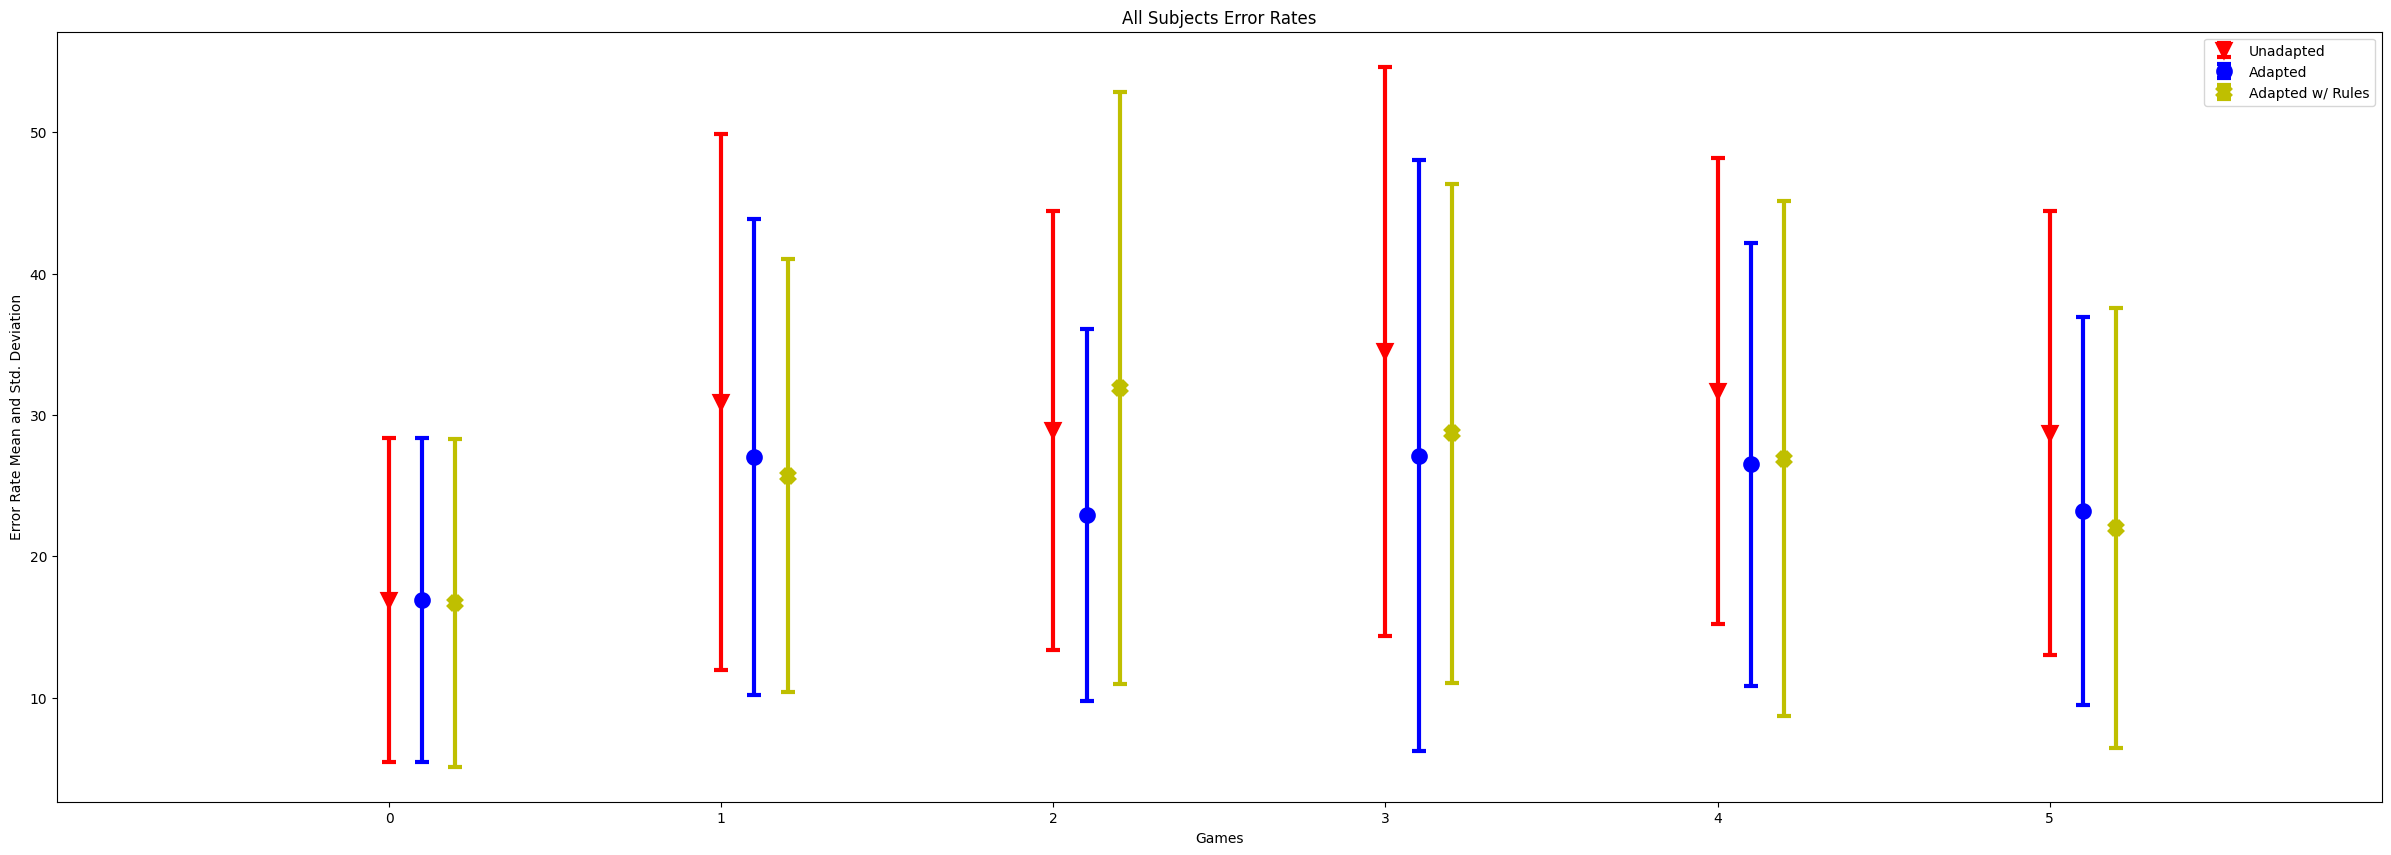

In [15]:
length = len(unadapted_means)
fig = plt.figure(figsize=(30, 10))
# plt.errorbar(np.arange(length), baseline_means, baseline_means, fmt='yo', lw=2, capsize=5, elinewidth=3, markersize=10, markeredgewidth=2, ecolor='y', markeredgecolor='y', markerfacecolor='y', label='Baseline')
plt.errorbar(np.arange(length), unadapted_means, unadapted_stds, fmt='rv', lw=2, capsize=5, elinewidth=3, markersize=9, markeredgewidth=3, ecolor='r', markeredgecolor='r', markerfacecolor='r', label='Unadapted')
# plt.errorbar(np.arange(length), unadapted_wrules_means, unadapted_wrules_stds, fmt='g^', lw=2, capsize=5, elinewidth=3, markersize=8, markeredgewidth=3, ecolor='g', markeredgecolor='g', markerfacecolor='g', label='Unadapted w/ Rules')
plt.errorbar(np.arange(length)+0.1, adapted_means, adapted_stds, fmt='bo', lw=2, capsize=5, elinewidth=3, markersize=9, markeredgewidth=3, ecolor='b', markeredgecolor='b', markerfacecolor='b', label='Adapted')
plt.errorbar(np.arange(length)+0.2, adapted_wrules_means, adapted_wrules_stds, fmt='mX', lw=2, capsize=5, elinewidth=3, markersize=9, markeredgewidth=3, ecolor='m', markeredgecolor='m', markerfacecolor='m', label='Adapted w/ Rules')
plt.xlim(-1, length)
plt.title("All Subjects Error Rates")
plt.ylabel("Error Rate Mean and Std. Deviation")
plt.xlabel("Games")
plt.xticks(np.arange(length))
plt.legend()
# plt.yticks(np.arange(0, 1400, 100))
plt.show()

# length = len(unadapted_wrules_means)
# fig = plt.figure(figsize=(30, 10))
# plt.errorbar(np.arange(length), unadapted_wrules_means, unadapted_wrules_stds, fmt='ok', lw=2, capsize=5, elinewidth=3, markeredgewidth=2)
# plt.xlim(-1, length)
# plt.title("All Subjects Error Rates Unadapted w/ Rules")
# plt.ylabel("Error Rate Mean and Std. Deviation")
# plt.xlabel("Games")
# plt.xticks(np.arange(length))
# # plt.yticks(np.arange(0, 1400, 100))
# plt.show()

## Manual Aggregation

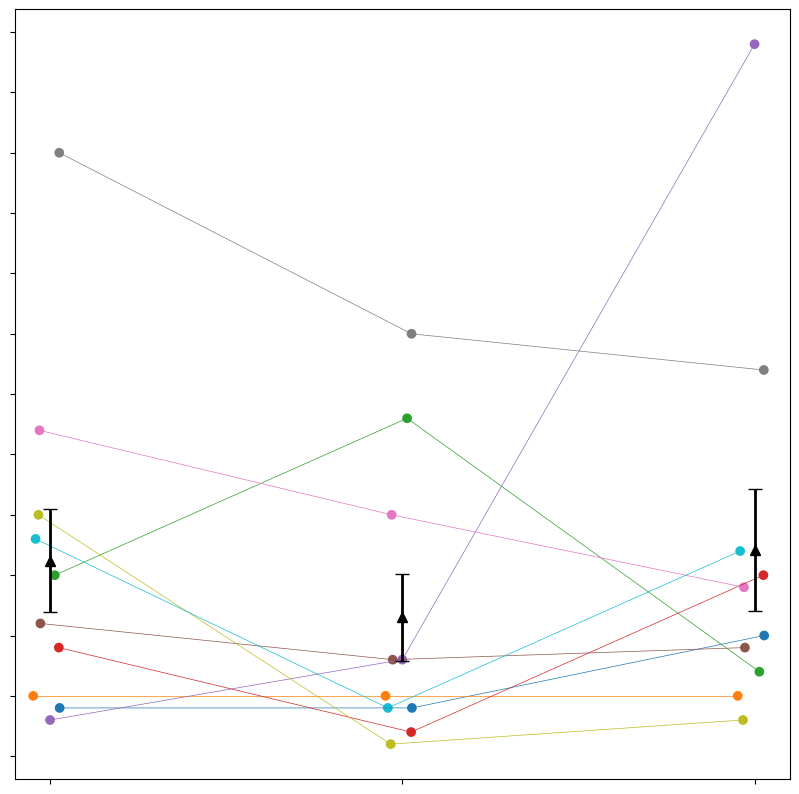

In [128]:
# Subject 1
sub1_unadapted = 43 - 44
sub1_adapted = 43 - 44
sub1_adaptedwrul = 49 - 44

# Subject 2 - no motion threshold failed
sub2_unadapted = 0
sub2_adapted = 0
sub2_adaptedwrul = 0

# Subject 3
sub3_unadapted = 16 - 6
sub3_adapted = 29 - 6
sub3_adaptedwrul = 7 - 5

# Subject 4
sub4_unadapted = 18 - 14
sub4_adapted = 11 - 14
sub4_adaptedwrul = 24 - 14

# Subject 5
sub5_unadapted = 10 - 12
sub5_adapted = 5 - 12
sub5_adaptedwrul = 66 - 12

# Subject 6
sub6_unadapted = 18 - 12
sub6_adapted = 15 - 12
sub6_adaptedwrul = 15 - 11

# Subject 7 - key error
sub7_unadapted = 44 - 22
sub7_adapted = 37 - 22
sub7_adaptedwrul = 31 - 22

# Subject 8 - key error
sub8_unadapted = 63 - 18
sub8_adapted = 48 - 18
sub8_adaptedwrul = 45 - 18

# Subject 9
sub9_unadapted = 41 - 26
sub9_adapted = 22 - 26
sub9_adaptedwrul = 24 - 26

# Subject 10
sub10_unadapted = 28 - 15
sub10_adapted = 14 - 15
sub10_adaptedwrul = 27 - 15

unadapted_list = [sub1_unadapted, sub2_unadapted, sub3_unadapted, sub4_unadapted, sub5_unadapted, sub6_unadapted, sub7_unadapted, sub8_unadapted, sub9_unadapted, sub10_unadapted]
adapted_list = [sub1_adapted, sub2_adapted, sub3_adapted, sub4_adapted, sub6_adapted, sub6_adapted, sub7_adapted, sub8_adapted, sub9_adapted, sub10_adapted]
adaptedwrul_list = [sub1_adaptedwrul, sub2_adaptedwrul, sub3_adaptedwrul, sub4_adaptedwrul, sub5_adaptedwrul, sub6_adaptedwrul, sub7_adaptedwrul, sub8_adaptedwrul, sub9_adaptedwrul, sub10_adaptedwrul]

fig = plt.figure(figsize=(10, 10))
np.random.seed(10)
rand_list = np.random.uniform(-0.05,0.05,10)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
plt.scatter(np.zeros(10) + rand_list, unadapted_list, color=colors)
plt.scatter(np.ones(10) + rand_list, adapted_list, color=colors)
plt.scatter(np.ones(10)*2 + rand_list, adaptedwrul_list, color=colors)
for i in range(10):
    plt.plot([rand_list[i], 1+rand_list[i], 2+rand_list[i]], [unadapted_list[i], adapted_list[i], adaptedwrul_list[i]], color=colors[i], linewidth=0.5)
plt.errorbar(range(3), [np.mean(unadapted_list), np.mean(adapted_list), np.mean(adaptedwrul_list)], [np.std(unadapted_list)/np.sqrt(len(unadapted_list)), np.std(adapted_list)/np.sqrt(len(adapted_list)), np.std(adaptedwrul_list)/np.sqrt(len(adaptedwrul_list))], fmt='k^', lw=2, capsize=5, markersize=7, markeredgewidth=1)
# plt.errorbar(range(3), [np.mean(unadapted_list), np.mean(adapted_list), np.mean(adaptedwrul_list)], [np.std(unadapted_list), np.std(adapted_list), np.std(adaptedwrul_list)], fmt='k^', lw=2, capsize=5, markersize=7, markeredgewidth=1)
plt.xlim(-0.1, 2.1)
# plt.title("All Subjects Difference Between Last and First Games")
# plt.ylabel("Change in Error Rate", fontsize=12)
# plt.xlabel("Models", fontsize=12)
# plt.xticks(np.arange(3), ['Unadapted', 'Adapted', 'Adapted w/ Rules'])
plt.xticks(np.arange(3), labels=[])
plt.yticks(np.arange(-5, 60, 5), labels=[])
plt.show()